## Benchmarking tips

In the `Julia is fast` notebook, we saw the package `BenchmarkTools` and used its `@benchmark` macro.

In this notebook, we'll explore the importance of "interpolating" global variables when benchmarking functions.

We interpolate a global variable by throwing a `$` in front of it. For example, in `Julia is fast`, we benchmarked the `sum` function using `Vector` `A` via

```julia
@benchmark sum($A)
```

not

```julia
@benchmark sum(A)
```

Let's see if this can make a difference by examining the ratio in execution times of `sum($A)` and `sum(A)` for differently sized arrays `A`. 

#### Exercise

Call the `sum` function on a pseudo-randomly populated 1D array called `foo` of several lengths between 2 and 2^20 (~10^6). For each size of `foo`, determine the ratio of execution times for `sum(foo)` and `sum($foo)`. (To determine this ratio, use the minimum run times in each case.)

Plot the ratio of execution times for non-interpolated and interpolated `foo` in calls to `sum` versus the length of `foo`. Does interpolating `foo` seem to matter? If so, for what sizes of `foo`?

#### Solution



In [6]:
using BenchmarkTools, Plots

In [7]:
gr()

Plots.GRBackend()

In [8]:
store_ratios = []
foo = rand()
for i in 1:20
    foo = rand(2^i) 
    not_interpolated = @benchmark sum(foo)
    interpolated = @benchmark sum($foo)
    min_not_interpolated = minimum(not_interpolated.times)
    min_interpolated = minimum(interpolated.times)
    ratio = min_not_interpolated / min_interpolated
    append!(store_ratios, ratio)
end

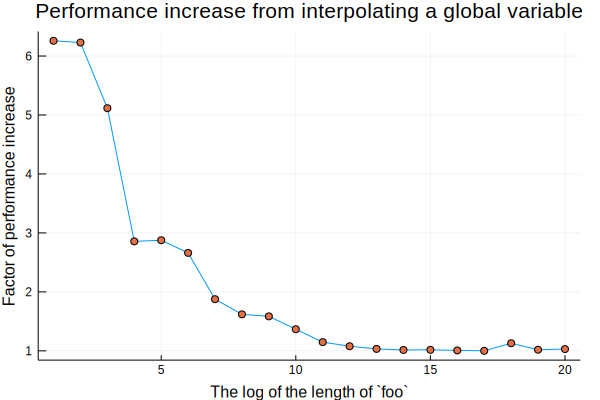

In [9]:
plot([i for i in 1:20], store_ratios, legend=false)
scatter!([i for i in 1:20], store_ratios)
xlabel!("The log of the length of `foo`")
ylabel!("Factor of performance increase")
title!("Performance increase from interpolating a global variable")

In this case, interpolating the global variable is more important when that global variable is bound to a relatively small array. For arrays with a few thousand elements and more, interpolation doesn't seem to have an impact.

## Performance tips -- type stability

One way to optimize code in Julia is to ensure **type stability**. If the type(s) of some variables in a function are subject to change or ambiguity, the compiler cannot reason as well about those variables, and performance will take a hit. Conversely, we allow the compiler to optimize and generate more efficient machine code when we declare variables so that their types will be fixed throughout the function body.

For example, let's say we had functions called `baz` and `bar` with the following definitions

```julia
function baz()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return 1//3    
    else
        return 0    
    end
end
```

```julia
function bar()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return .3333333    
    else
        return 0.0    
    end
end
```

When I benchmark these via

```julia
using BenchmarkTools
@benchmark baz()
@benchmark bar()
```

I see that `bar` is almost three times as fast as `baz`! The reason is that `bar` is type stable while `baz` is not: the compiler can tell that `bar` will always return a `Float`, whereas `baz` could return a `Float`, an `Int`, or a `Rational`. When the compiler can tell what the types of outputs from a function, or variables declared *within a function* are without running the code, it can do much better.

#### Exercise

The following definition for `my_sum` is not type stable. 

```julia
function my_sum(A)
    output = 0
    for x in A
        output += x
    end
    return output
end
```

Copy and execute the above code into a new cell. Benchmark it using `A = rand(10^3)`. Then write a new function called `my_sum2` with the same function body as `my_sum`. Update `my_sum2` to make it type stable, and benchmark it for a randomly populated array with 10^3 entries.

How much does type stability impact performance? If you'd like, try this same exercise for multiple sizes of `A` to see if this changes your answer!

#### Solution

In [1]:
function my_sum(A)
    output = 0
    for x in A
        output += x
    end
    return output
end

my_sum (generic function with 1 method)

In [3]:
using BenchmarkTools

A = rand(10^3)
@benchmark my_sum($A)


BenchmarkTools.Trial: 
  memory estimate:  46.86 KiB
  allocs estimate:  2999
  --------------
  minimum time:     20.717 μs (0.00% GC)
  median time:      22.574 μs (0.00% GC)
  mean time:        26.536 μs (6.19% GC)
  maximum time:     1.326 ms (84.65% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [4]:
function my_sum2(A)
    output = zero(eltype(A))
    # or:
    # output = 0.0
    for x in A
        output += x
    end
    return output
end

my_sum2 (generic function with 1 method)

In [5]:
@benchmark my_sum2($A)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     902.119 ns (0.00% GC)
  median time:      902.619 ns (0.00% GC)
  mean time:        1.113 μs (0.00% GC)
  maximum time:     105.412 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     42

In my run, `my_sum2` outperformed `my_sum` by a factor of over 20 for an array with 1000 elements!

#### Exercise

Make the following code type stable. You'll know your efforts are paying off when you see a performance boost!

```julia
"""
    my_sqrt(x)
    
Calculate the square root of `x` with Newton's method.
"""
function my_sqrt(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end
```

#### Solution

You need to make sure `ouptut`'s type never changes in order to make this function type stable!

In [15]:
# The type unstable version
function my_sqrt(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt (generic function with 1 method)

In [16]:
@benchmark my_sqrt(100)

BenchmarkTools.Trial: 
  memory estimate:  78.09 KiB
  allocs estimate:  4998
  --------------
  minimum time:     39.939 μs (0.00% GC)
  median time:      50.347 μs (0.00% GC)
  mean time:        78.705 μs (12.54% GC)
  maximum time:     7.488 ms (93.74% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [17]:
# The type stable version, where `output` is always a floating point number.
function my_sqrt(x)
    output = 1.0
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt (generic function with 1 method)

In [18]:
@benchmark my_sqrt(100)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.992 μs (0.00% GC)
  median time:      6.033 μs (0.00% GC)
  mean time:        6.547 μs (0.00% GC)
  maximum time:     28.872 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     6